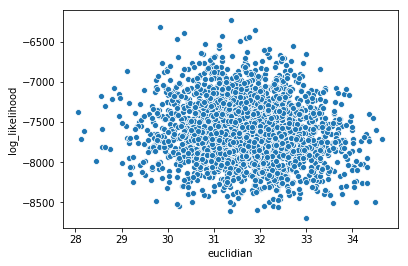

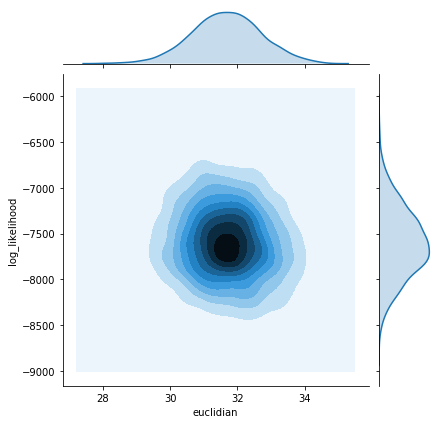

In [11]:
from scgenome import utils
from scipy.spatial.distance import pdist, squareform
from itertools import combinations
import numpy as np
from scgenome.jointcnmodels import get_variances, get_tr_probs, calculate_marginal_ll_simple
from scipy import special
import seaborn as sns
import pandas as pd

n_cell = 70
n_bin = 500
n_state = 4
seed = 2

#cluster1 = cn_mat_poisson(samples_per_cluster, num_bin,
#                          init_lambda=init_lambdas[0],
#                          jump_lambda=jump_lambdas[0], seed=seeds[0],
#                          max_cn=max_cn)
np.random.seed(seed)
cluster1 = np.concatenate([np.random.normal(size=n_bin)[np.newaxis,:] for i in range(n_cell)])
clst1_cell_ids = [f"cl1_cell{i}" for i in range(n_cell)]
cn_mat = cluster1
cell_ids = clst1_cell_ids

chr_names = ["1", "2"]
df_cn_mat = utils.cn_mat_as_df(cn_mat, chr_names)
cn_data = utils.cn_mat_to_cn_data(df_cn_mat, cell_id_vals=cell_ids)
cn_data["cluster_id"] = cn_data["cell_id"].str.split("_", expand=True).iloc[:, 0]
np.random.seed(1)
cn_data["copy2"] = cn_data["copy"] + np.absolute(np.random.normal(size=cn_data.shape[0], scale=0.3))
cn_data.columns = ["chr", "bin", "cell_id", "state", "start", "end","cluster_id", "copy"]

matrix_data, measurement, cell_ids = utils.cn_data_to_mat_data_ids(cn_data, value_ids=["copy"])
variances = get_variances(cn_data, matrix_data, n_state)
tr_probs = get_tr_probs(n_bin, n_state)
tr_mat = np.log(tr_probs)

pw_euc = squareform(pdist(cn_mat))

pw_ll = np.zeros((n_cell, n_cell))
for i,j in combinations(range(n_cell), 2):
    pw_ll[i, j] = calculate_marginal_ll_simple(measurement[[i,j], :], variances[[i,j], :], tr_mat)

pwd = pd.DataFrame({"euclidian" : pw_euc[np.triu_indices(n_cell,1)],
                    "log_likelihood" : pw_ll[np.triu_indices(n_cell,1)]})
sns.scatterplot(data=pwd, x="euclidian", y="log_likelihood")
sns.jointplot(data=pwd, x="euclidian", y="log_likelihood", kind="kde")

In [17]:
sum((cn_mat[0,:] - cn_mat[1,:])**2)**0.5

30.988042892548794

In [12]:
pw_euc

array([[ 0.        , 30.98804289, 31.82838566, ..., 32.03855084,
        32.40225677, 32.90686509],
       [30.98804289,  0.        , 31.56414923, ..., 31.2849748 ,
        30.41000579, 31.282114  ],
       [31.82838566, 31.56414923,  0.        , ..., 31.31081775,
        30.54465633, 33.10146208],
       ...,
       [32.03855084, 31.2849748 , 31.31081775, ...,  0.        ,
        32.18035399, 32.74232728],
       [32.40225677, 30.41000579, 30.54465633, ..., 32.18035399,
         0.        , 31.68167703],
       [32.90686509, 31.282114  , 33.10146208, ..., 32.74232728,
        31.68167703,  0.        ]])